<a href="https://colab.research.google.com/github/Probingbug/seminar/blob/main/MTP_phase_1_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATASET CREATION**

In [4]:
import zipfile
import os

with zipfile.ZipFile("/moon_images.zip", 'r') as zip_ref:
    zip_ref.extractall("moon_regions")  # folder will be created

In [5]:
import cv2
import numpy as np
import os
import random
import glob
from tqdm import tqdm

def generate_and_save_patches(image_folders, save_dir, patch_size=32, patches_per_image=128):
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)

    all_labels = []
    count = 0

    for folder in image_folders:
        image_paths = glob.glob(os.path.join(folder, '*.png')) + glob.glob(os.path.join(folder, '*.jpg'))

        for path in tqdm(image_paths, desc=f"Processing {folder}"):
            image = cv2.imread(path)
            if image is None:
                print(f"Skipping {path}")
                continue

            h, w = image.shape[:2]

            for _ in range(patches_per_image):
                x = random.randint(0, w - patch_size)
                y_coord = random.randint(0, h - patch_size)
                patch = image[y_coord:y_coord+patch_size, x:x+patch_size]

                patch_filename = f"patch_{count:05d}.png"
                patch_path = os.path.join(save_dir, "images", patch_filename)
                cv2.imwrite(patch_path, patch)

                all_labels.append([x, y_coord])
                count += 1

    all_labels = np.array(all_labels)
    np.save(os.path.join(save_dir, "labels.npy"), all_labels)
    print(f"\n✅ Saved {count} patches and labels to '{save_dir}'")

# Step 2: Use it on your uploaded folder
base_dir = "/content/moon_regions"
save_dir = "/content/moon_patches_dataset"
subfolders = [os.path.join(base_dir, sub) for sub in ['Equirectangular', 'South Pole', 'north pole']]

generate_and_save_patches(
    image_folders=subfolders,
    save_dir=save_dir,
    patch_size=32,
    patches_per_image=128  # ~9600 total patches
)

Processing /content/moon_regions/north pole: 100%|██████████| 22/22 [00:01<00:00, 20.84it/s]



✅ Saved 8704 patches and labels to '/content/moon_patches_dataset'


In [6]:
import numpy as np

labels = np.load("/content/moon_patches_dataset/labels.npy")
print("Labels shape:", labels.shape)
print("First 5 coordinates:", labels[:5])

Labels shape: (8704, 2)
First 5 coordinates: [[ 598  653]
 [1439  767]
 [1583  376]
 [1247  683]
 [1735  683]]


**DATA PREPARATION**

In [48]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def extract_patch_sequence(image, patch_size=32, seq_len=5):
    h, w = image.shape[:2]
    rows, cols = h // patch_size, w // patch_size
    visited = set()
    sequence = []
    coords = []

    # Start from a random grid cell
    r, c = random.randint(0, rows - 1), random.randint(0, cols - 1)

    for _ in range(seq_len):
        if (r, c) in visited:
            break

        visited.add((r, c))
        x, y = c * patch_size, r * patch_size

        patch = image[y:y+patch_size, x:x+patch_size]
        sequence.append(patch)

        # Normalize (x, y)
        coords.append([x / w, y / h])

        # Move to random adjacent cell
        neighbors = []
        if r > 0: neighbors.append((r-1, c))
        if r < rows-1: neighbors.append((r+1, c))
        if c > 0: neighbors.append((r, c-1))
        if c < cols-1: neighbors.append((r, c+1))

        random.shuffle(neighbors)
        for nr, nc in neighbors:
            if (nr, nc) not in visited:
                r, c = nr, nc
                break

    if len(sequence) == seq_len:
        return np.array(sequence), np.array(coords)
    return None, None

def generate_dataset(parent_folder, patch_size=32, seq_len=5, max_sequences=10000):
    image_paths = []
    print(f"Searching for images in: {parent_folder}") # Debug print
    if not os.path.isdir(parent_folder):
        print(f"Error: Parent folder '{parent_folder}' not found.")
        return np.array([]), np.array([]) # Return empty arrays if folder not found

    for subdir in os.listdir(parent_folder):
        full_subdir = os.path.join(parent_folder, subdir)
        print(f"Checking subdirectory: {full_subdir}") # Debug print
        # Check if full_subdir is a directory before listing files
        if os.path.isdir(full_subdir):
            for file in os.listdir(full_subdir):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(full_subdir, file))
            print(f"Found {len(image_paths)} images so far.") # Debug print

    print(f"Total image paths found: {len(image_paths)}") # Debug print

    X, y = [], []

    for path in tqdm(image_paths, desc="Generating sequences"):
        image = cv2.imread(path)
        if image is None: continue
        image = cv2.resize(image, (512, 512))  # resize for consistency

        for _ in range(10):  # generate 10 sequences per image
            patch_seq, coord_seq = extract_patch_sequence(image, patch_size, seq_len)
            if patch_seq is not None:
                X.append(patch_seq)
                y.append(coord_seq)
            if len(X) >= max_sequences:
                break
        if len(X) >= max_sequences:
            break

    X = np.array(X)  # shape: (N, seq_len, patch_size, patch_size, 3)
    y = np.array(y)  # shape: (N, seq_len, 2)

    return X, y


if __name__ == "__main__":
    parent_folder = "moon_regions"  # adjust as needed
    X, y = generate_dataset(parent_folder)
    # os.makedirs("data", exist_ok=True)
    # np.save("data/patch_sequences.npy", X)
    # np.save("data/trajectory_labels.npy", y)
     # 🟡 Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # 🟢 Save datasets
    os.makedirs("data", exist_ok=True)
    np.save("data/X_train.npy", X_train)
    np.save("data/X_val.npy", X_val)
    np.save("data/y_train.npy", y_train)
    np.save("data/y_val.npy", y_val)

Searching for images in: moon_regions
Checking subdirectory: moon_regions/__MACOSX
Found 0 images so far.
Checking subdirectory: moon_regions/north pole
Found 22 images so far.
Checking subdirectory: moon_regions/South Pole
Found 43 images so far.
Checking subdirectory: moon_regions/Equirectangular
Found 68 images so far.
Total image paths found: 68


Generating sequences: 100%|██████████| 68/68 [00:01<00:00, 38.37it/s]


**model**

In [49]:
#second model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, LSTM
)
from tensorflow.keras.regularizers import l2



def build_trajectory_predictor(input_shape=(500, 32, 32, 3)):
    """
    input_shape: (sequence_length, patch_height, patch_width, channels)
    output: sequence of (x, y) positions
    """
    inp = Input(shape=input_shape)

    # TimeDistributed CNN feature extractor
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(1e-4)))(inp)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(1e-4)))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(1e-4)))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)

    # LSTM to learn sequence
    x = LSTM(512, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    # Output 2D position per timestep
    out = TimeDistributed(Dense(2, activation='linear'))(x)

    model = Model(inputs=inp, outputs=out)
    return model

In [50]:
import importlib
import model
importlib.reload(model)  # ensure latest code loaded

from model import build_trajectory_predictor
model = build_trajectory_predictor(input_shape=(5, 32, 32, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

ModuleNotFoundError: No module named 'model'

In [71]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Concatenate, Dropout
)
import tensorflow as tf
from tensorflow.keras.regularizers import l2

def build_trajectory_predictor2(input_shape=(None, 32, 32, 3), use_positional_encoding=True):
    """
    input_shape: (sequence_length, patch_height, patch_width, channels)
    Returns a model that predicts trajectory points (x, y) from image sequences.
    """
    patch_sequence = Input(shape=input_shape, name="image_sequence")

    if use_positional_encoding:
        position_input = Input(shape=(input_shape[0], 2), name="position_sequence")  # (seq_len, 2)

    # CNN Feature Extraction per patch
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(patch_sequence)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)  # shape: (batch, seq_len, features)

    if use_positional_encoding:
        # Concatenate position info with features
        x = Concatenate()([x, position_input])  # (batch, seq_len, features + 2)

    # LSTM to learn trajectory over time
    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    output = TimeDistributed(Dense(2, activation='linear'))(x)  # output x, y coords

    if use_positional_encoding:
        model = Model(inputs=[patch_sequence, position_input], outputs=output)
    else:
        model = Model(inputs=patch_sequence, outputs=output)

    return model

In [72]:
from tensorflow.keras.losses import Huber

# Build the model
model = build_trajectory_predictor2(input_shape=(None, 32, 32, 3), use_positional_encoding=False)

# Compile it
model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

# Print summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_sequence (InputLayer)     │ (None, None, 32, 32,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_68             │ (None, None, 32, 32,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_69             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_70             │ (None, None, 16, 16,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_71             │ (None, None, 8, 8, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_72             │ (None, None, 8, 8, 32) │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_73             │ (None, None, 4, 4, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_74             │ (None, None, 4, 4, 16) │         4,624 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_75             │ (None, None, 2, 2, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_76             │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, None, 256)      │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_77             │ (None, None, 2)        │           514 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,698 (1.42 MB)

 Trainable params: 371,698 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
from tensorflow.keras.callbacks import Callback

class PrintEvery50Epochs(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
            print(f"\n📣 Epoch {epoch + 1}: loss = {logs['loss']:.4f}, val_loss = {logs['val_loss']:.4f}")

In [74]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4), loss=Huber(delta=1.0), metrics=['mae'])

In [75]:
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[PrintEvery50Epochs()]
)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.1656 - mae: 0.4454 - val_loss: 0.0658 - val_mae: 0.2805
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1003 - mae: 0.3482 - val_loss: 0.0549 - val_mae: 0.2581
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0873 - mae: 0.3233 - val_loss: 0.0537 - val_mae: 0.2555
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0846 - mae: 0.3137 - val_loss: 0.0536 - val_mae: 0.2543
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0775 - mae: 0.3026 - val_loss: 0.0538 - val_mae: 0.2568
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0776 - mae: 0.3021 - val_loss: 0.0540 - val_mae: 0.2567
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0734 - mae: 0.2936 - val_loss: 0.0531 - val_mae: 0.2579
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0694 - mae: 0.2868 - val_loss: 0.0521 - val_mae: 0.2545
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

In [76]:
model.save("trajectory_predictor_model.h5")

In [77]:
predictions = model.predict(X_val)

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


In [78]:
import numpy as np

def evaluate_predictions(y_true, y_pred):
    distances = np.linalg.norm(y_true - y_pred, axis=-1)  # shape: (batch, seq_len)
    avg_distance = np.median(distances)
    print(f"📏 Average Pixel Distance Error: {avg_distance:.2f} pixels")

evaluate_predictions(y_val, predictions)

📏 Average Pixel Distance Error: 0.37 pixels


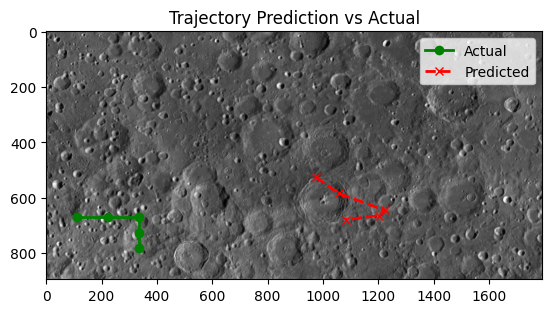

In [79]:
import matplotlib.pyplot as plt

def plot_prediction_vs_actual(index, X_val, y_val, predictions, background_image):
    fig, ax = plt.subplots()

    # Load and show moon image as background
    moon_img = plt.imread(background_image)
    ax.imshow(moon_img)

    # Image dimensions
    img_h, img_w = moon_img.shape[:2]

    # Denormalize true and predicted paths
    true_path = y_val[index] * [img_w, img_h]
    pred_path = predictions[index] * [img_w, img_h]

    # Plot actual trajectory
    ax.plot(true_path[:, 0], true_path[:, 1], 'o-', label='Actual', color='green', linewidth=2)

    # Plot predicted trajectory
    ax.plot(pred_path[:, 0], pred_path[:, 1], 'x--', label='Predicted', color='red', linewidth=2)

    ax.legend()
    plt.title("Trajectory Prediction vs Actual")
    plt.show()

# Example usage
plot_prediction_vs_actual(0, X_val, y_val, predictions, background_image="/content/moon_regions/Equirectangular/Equi_1.png")



In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def evaluate_predictions(y_true, y_pred):
    """Evaluate the model predictions by computing average pixel distance."""
    distances = np.linalg.norm(y_true - y_pred, axis=-1)  # shape: (batch, seq_len)
    avg_distance = np.mean(distances)
    print(f"\U0001F4CF Average Pixel Distance Error: {avg_distance:.2f} pixels")

def denormalize_coords(coords, image_shape):
    """Convert normalized coordinates [0,1] to pixel values based on image size."""
    h, w = image_shape[:2]
    return coords * np.array([w, h])

def plot_prediction_vs_actual(index, X_val, y_val, predictions, bg_image_path=None):
    """Visualize predicted vs actual trajectory on the background image."""
    fig, ax = plt.subplots(figsize=(10, 6))

    if bg_image_path:
        bg_image = cv2.imread(bg_image_path)
        bg_image = cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB)
        ax.imshow(bg_image)
        image_shape = bg_image.shape
    else:
        # fallback to the middle patch image if no background given
        bg_image = X_val[index][len(X_val[index]) // 2]  # use center patch as background
        ax.imshow(bg_image)
        image_shape = bg_image.shape

    # Denormalize
    true_path = denormalize_coords(y_val[index], image_shape)
    pred_path = denormalize_coords(predictions[index], image_shape)

    # Plot
    ax.plot(true_path[:, 0], true_path[:, 1], 'o-', label='Actual', color='green', linewidth=2)
    ax.plot(pred_path[:, 0], pred_path[:, 1], 'x--', label='Predicted', color='red', linewidth=2)
    ax.legend()
    plt.title("Trajectory Prediction vs Actual")
    plt.axis('on')
    plt.show()

# Usage (run after prediction)
# evaluate_predictions(y_val, predictions)
# plot_prediction_vs_actual(0, X_val, y_val, predictions, bg_image_path="/content/moon_regions/Equirectangular/sample_bg.png")

📏 Average Pixel Distance Error: 0.37 pixels


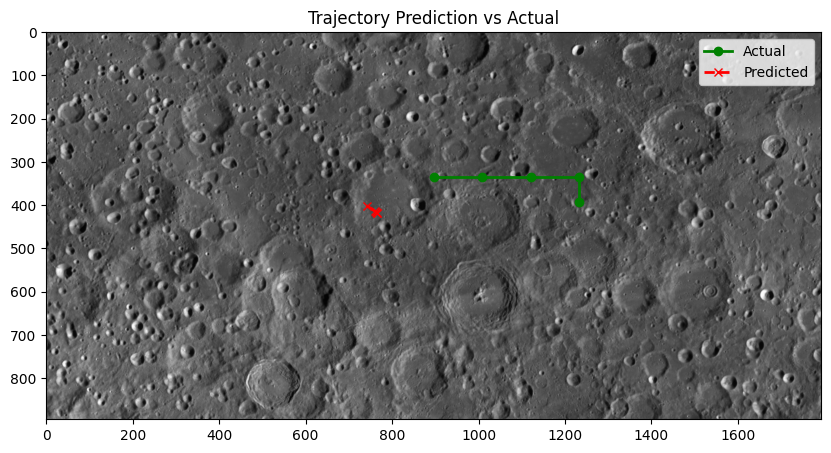

In [31]:
evaluate_predictions(y_val, predictions)
plot_prediction_vs_actual(0, X_val, y_val, predictions, bg_image_path="/content/moon_regions/Equirectangular/Equi_1.png")


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def denormalize_coords(coords, image_shape):
    """Convert normalized [0, 1] coordinates to pixel positions."""
    h, w = image_shape[:2]
    return coords * np.array([w, h])

def plot_patch_trajectory(index, X_val, y_val, predictions, bg_image_path):
    """
    Overlays predicted and actual patch trajectories over the full moon map.
    Draws rectangles for patch centers and lines between them.
    """
    # Load the full moon background image
    bg = cv2.imread(bg_image_path)
    bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
    H, W = bg.shape[:2]

    # Denormalize predicted and true trajectories
    true_coords = denormalize_coords(y_val[index], bg.shape)
    pred_coords = denormalize_coords(predictions[index], bg.shape)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(bg)
    ax.set_title("Predicted vs Actual Patch Trajectory")

    patch_size = 32

    # Draw actual trajectory
    for i, pt in enumerate(true_coords):
        x, y = pt
        rect = plt.Rectangle((x - patch_size // 2, y - patch_size // 2),
                             patch_size, patch_size, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, str(i+1), color='green', fontsize=10, ha='center')
    ax.plot(true_coords[:, 0], true_coords[:, 1], color='green', label='Actual', linestyle='-', marker='o')

    # Draw predicted trajectory
    for i, pt in enumerate(pred_coords):
        x, y = pt
        rect = plt.Rectangle((x - patch_size // 2, y - patch_size // 2),
                             patch_size, patch_size, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, str(i+1), color='red', fontsize=10, ha='center')
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], color='red', label='Predicted', linestyle='--', marker='x')

    ax.legend()
    plt.axis('off')
    plt.show()

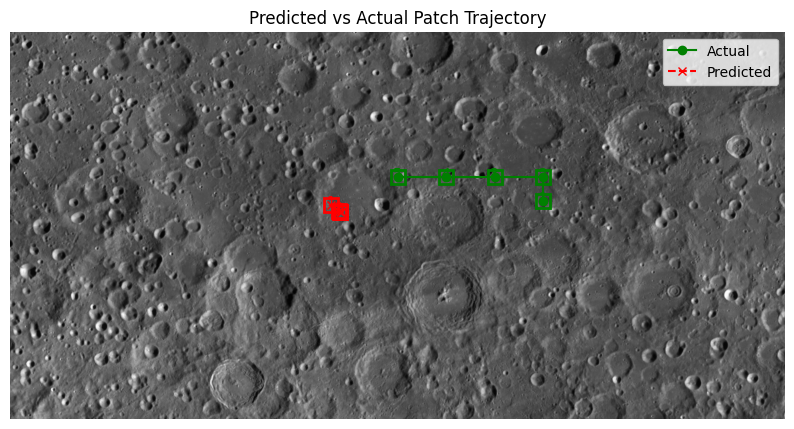

In [33]:
# Example usage
plot_patch_trajectory(
    index=0,
    X_val=X_val,
    y_val=y_val,
    predictions=predictions,
    bg_image_path="/content/moon_regions/Equirectangular/Equi_1.png"  # your original image path
)

In [34]:
def debug_one_sample(y_true, y_pred):
    dists = np.linalg.norm(y_true - y_pred, axis=-1)
    print("Step-wise distances:", dists)
    print("Avg distance:", np.mean(dists))

debug_one_sample(y_val[0], predictions[0])

Step-wise distances: [0.2739638  0.27746256 0.2185405  0.16365746 0.11685382]
Avg distance: 0.21009562984807234
